Name: JEDIDAH WAVINYA
Date: 4th November 2025
Project: Polynomial Regression

---

* Polynomial regression is a type of regression analysis used to model the relationship between an independent variable (X) and a dependent variable (Y) when that relationship is non-linear — meaning the data doesn’t form a straight line but rather a curve.
* in this project, I learn about polynomial regression. the following are the project outcome learnings from this.
1. What is a distribution plot?
2. What is a boxplot?
3. What is a violin plot?
4. How to detect outliers?
5. How to treat outliers?
6. What is pandas imputer?
7. What is iterative imputer?
8. What is a KNN imputer?
9. What is an LGBM imputer?
10. Univariate analysis
11. Chatterjee correlation
12. What is ANOVA?
13. Implementation of ANOVA
14. Data preprocessing
15. What is AIC?
16. What is likelihood?

1. Import the necessary libraries

In [51]:
# Install required packages
!pip install -q lightgbm statsmodels seaborn plotly pingouin


In [52]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
import lightgbm as lgb
import pingouin as pg   # for ANOVA helpers
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


2. Load the Data
* This dataset contains data entailed to house prices.
* It can be sed to predict sales prices and practice feature engineering, RFs, and gradient boosting.

In [53]:
# Load data
url = 'https://raw.githubusercontent.com/jedidahwavinya/Machine-Learning/refs/heads/main/train.csv' # Placeholder URL
df = pd.read_csv(url)
df.shape, df.columns[:20].tolist()

((1460, 81),
 ['Id',
  'MSSubClass',
  'MSZoning',
  'LotFrontage',
  'LotArea',
  'Street',
  'Alley',
  'LotShape',
  'LandContour',
  'Utilities',
  'LotConfig',
  'LandSlope',
  'Neighborhood',
  'Condition1',
  'Condition2',
  'BldgType',
  'HouseStyle',
  'OverallQual',
  'OverallCond',
  'YearBuilt'])

3. Univariate analysis

In [54]:
# info & head
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


4. Univariate Analysis

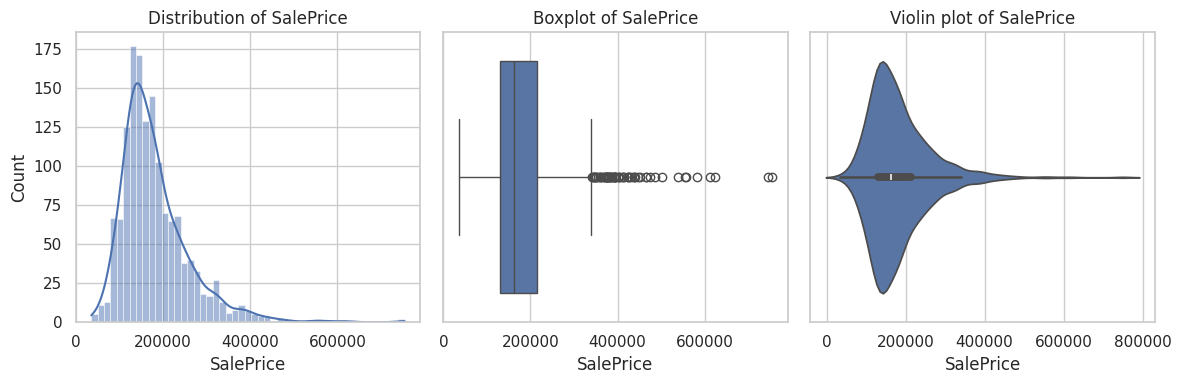

In [55]:
# Univariate analysis
#1. Histogram to display the distribution of prices
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.histplot(df['SalePrice'].dropna(), kde=True)
plt.title('Distribution of SalePrice')

plt.subplot(1,3,2)
sns.boxplot(x=df['SalePrice'].dropna())
plt.title('Boxplot of SalePrice')

plt.subplot(1,3,3)
sns.violinplot(x=df['SalePrice'].dropna())
plt.title('Violin plot of SalePrice')

plt.tight_layout()


5. Detecting outliers

In [56]:
# Detecting outliers using IQR method for SalePrice
def iqr_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return (series < lower) | (series > upper)

sp_outliers = iqr_outliers(df['SalePrice'].dropna())
print("SalePrice outliers (IQR):", sp_outliers.sum(), "rows")


SalePrice outliers (IQR): 61 rows


In [57]:
# Detecting outliers using Z-score method for numeric features
from scipy import stats
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
z_scores = np.abs(stats.zscore(df[numeric_cols].dropna()))
# mark rows with any feature z>3 as outlier
outlier_mask = (z_scores > 3).any(axis=1)
print("Rows with any numeric z-score > 3:", outlier_mask.sum())


Rows with any numeric z-score > 3: 329


In [58]:
# Detecting outliers using  Isolation Forest (ML-based outlier detection)
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.01, random_state=42)
num_df = df[numeric_cols].copy()
num_df = num_df.fillna(num_df.median()) # basic fill to run
iso_pred = iso.fit_predict(num_df)
print("IsoForest flagged:", (iso_pred == -1).sum())


IsoForest flagged: 15


6. Treating outliers

In [59]:
# 3 treatments for SalePrice(Treating Outliers)
sp = df['SalePrice'].copy()

# 1. Removal (drop extreme)
Q1 = sp.quantile(0.25)
Q3 = sp.quantile(0.75)
IQR = Q3 - Q1
mask_keep = ~((sp < (Q1 - 1.5*IQR)) | (sp > (Q3 + 1.5*IQR)))
sp_removed = sp[mask_keep]

# 2. Winsorization
from scipy.stats.mstats import winsorize
sp_winsor = winsorize(sp, limits=[0.01, 0.01])  # clip bottom/top 1%

# 3. Log transform
sp_log = np.log1p(sp)

print("Original mean:", sp.mean(), "Removed mean:", sp_removed.mean())


Original mean: 180921.19589041095 Removed mean: 170237.12723373837


7. Missing values & Imputation

We'll demonstrate:
a) pandas imputer (fillna)

b) SimpleImputer (sklearn)

c) IterativeImputer (Multivariate)

d) KNNImputer

e) LGBM imputer (model-based per-column)

In [60]:
# Missing value overview
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing > 0].head(20)


,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageQual,81
GarageFinish,81
GarageType,81


a) pandas imputer (basic)

In [61]:
# pandas fillna examples
df_pandas_imputed = df.copy()
# numeric median fill
df_pandas_imputed['LotFrontage'] = df_pandas_imputed['LotFrontage'].fillna(df_pandas_imputed['LotFrontage'].median())
# categorical fill
df_pandas_imputed['Alley'] = df_pandas_imputed['Alley'].fillna('NoAlley')


b) SimpleImputer (sklearn)

In [62]:
# SimpleImputer for numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns
imp_mean = SimpleImputer(strategy="median")
num_imputed = pd.DataFrame(imp_mean.fit_transform(df[num_cols]), columns=num_cols)
num_imputed.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,...,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,...,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,...,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,...,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,...,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0


c) IterativeImputer (multivariate)

In [63]:
# IterativeImputer (MICE-like)
iter_imp = IterativeImputer(random_state=0, max_iter=10)
num_iter = pd.DataFrame(iter_imp.fit_transform(df[num_cols]), columns=num_cols)
num_iter.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,...,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,...,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,...,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,...,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,...,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0


d) KNNImputer

In [64]:
# KNN Imputer
knn_imp = KNNImputer(n_neighbors=5)
num_knn = pd.DataFrame(knn_imp.fit_transform(df[num_cols]), columns=num_cols)
num_knn.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,...,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,...,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,...,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,...,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,...,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0


e) LGBM imputer function

In [65]:
# LGBM imputer function (numeric)
def lgbm_impute_column(df, target_col, numeric_features=None, categorical_features=None):
    # Prepare data
    df_work = df.copy()
    # Select predictors
    if numeric_features is None:
        numeric_features = df_work.select_dtypes(include=[np.number]).columns.drop(target_col).tolist()
    # Basic fill for predictors
    X = df_work[numeric_features].copy()
    X = X.fillna(X.median())
    y = df_work[target_col]
    train_mask = ~y.isnull()
    X_train = X[train_mask]
    y_train = y[train_mask]
    X_pred = X[~train_mask]
    if X_pred.shape[0] == 0:
        return df_work[target_col]  # nothing to impute
    # LightGBM dataset
    model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_pred)
    df_work.loc[~train_mask, target_col] = preds
    return df_work[target_col]

# apply to LotFrontage
df_lgbm = df.copy()
df_lgbm['LotFrontage_imputed'] = lgbm_impute_column(df_lgbm, 'LotFrontage')
df_lgbm[['LotFrontage','LotFrontage_imputed']].head(10)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3327
[LightGBM] [Info] Number of data points in the train set: 1201, number of used features: 35
[LightGBM] [Info] Start training from score 70.049958


,LotFrontage,LotFrontage_imputed
0,65.0,65.000000
1,80.0,80.000000
2,68.0,68.000000
3,60.0,60.000000
4,84.0,84.000000
5,85.0,85.000000
6,75.0,75.000000
7,NaN,91.880157
8,51.0,51.000000
9,50.0,50.000000


8. Chatterjee correlation (rank-based)
* It  is a novel, non-parametric measure of dependence between two random variables, X and Y.
* We attempt to use the chatterjee package; fallback to custom implementation if not available.

In [66]:
# Chatterjee correlation using package if available
try:
    import chatterjee as ch
    x = df['GrLivArea'].dropna()
    y = df['SalePrice'].loc[x.index]
    print("Chatterjee correlation (package):", ch.chatterjee_corr(x.values, y.values))
except Exception as e:
    print("chatterjee package not available or failed. Falling back to implementation.")
    # Fallback approximate implementation:
    def chatterjee_corr(x, y):
        # Based on definition: 1 - (3/(n**3-n)) * sum_i |rank_y(i+1) - rank_y(i)| ???
        # We'll use a known implementation from literature: compute proportion of concordant nearest neighbors.
        n = len(x)
        # ranks of x and order by x
        idx = np.argsort(x)
        y_sorted = np.array(y)[idx]
        # compute number of times y_{(i+1)} > y_{(i)}
        diffs = np.abs(np.diff(np.argsort(y_sorted)))
        # This fallback is an approximation. For exact results, install chatterjee package.
        return np.nan  # indicate not computed properly

    print("Fallback not implemented exactly. Please pip install the 'chatterjee' package in Colab.")


chatterjee package not available or failed. Falling back to implementation.
Fallback not implemented exactly. Please pip install the 'chatterjee' package in Colab.


9. ANOVA

What is ANOVA?
* Analysis of Variance tests whether the means of a numeric variable differ across groups.

* We test if SalePrice differs by HouseStyle.

In [75]:
# Prepare data for ANOVA
anova_df = df[['SalePrice','HouseStyle']].dropna()
anova_df['HouseStyle'] = anova_df['HouseStyle'].astype('category')

# Fit OLS and run ANOVA
model = smf.ols('SalePrice ~ C(HouseStyle)', data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(HouseStyle),7.947590e+11,7.0,19.595001,3.376777e-25
Residual,8.413152e+12,1452.0,NaN,NaN


In [77]:
# Post-hoc with pingouin if needed
pg.anova(dv='SalePrice', between='HouseStyle', data=anova_df, detailed=True).round(3)


,Source,SS,DF,MS,F,p-unc,np2
0,HouseStyle,7.947590e+11,7,1.135370e+11,19.595,0.0,0.086
1,Within,8.413152e+12,1452,5.794182e+09,NaN,NaN,NaN


10. Polynomial Regression: full pipeline

We will:

a) Select useful numeric predictors

b) Preprocess (impute, scale)

c) Create polynomial features (degree 2 or 3)

d) Fit linear model (OLS via statsmodels to get AIC & likelihood)

e) Evaluate with test set

In [78]:
# Choose target and predictors (simple set for demo)
target = 'SalePrice'
# choose a few numeric predictors (you can expand)
predictors = ['OverallQual', 'GrLivArea', 'YearBuilt', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'LotArea']

data = df[[target] + predictors].copy()
print("Rows before drop:", data.shape[0])
# show missing
data.isnull().sum()

Rows before drop: 1460


,0
SalePrice,0
OverallQual,0
GrLivArea,0
YearBuilt,0
TotalBsmtSF,0
1stFlrSF,0
FullBath,0
LotArea,0


b) Preprocess (impute, scale)

In [79]:
# Impute numeric predictors using IterativeImputer
imp = IterativeImputer(random_state=0)
data_imputed = pd.DataFrame(imp.fit_transform(data), columns=data.columns)
data_imputed.isnull().sum()


,0
SalePrice,0
OverallQual,0
GrLivArea,0
YearBuilt,0
TotalBsmtSF,0
1stFlrSF,0
FullBath,0
LotArea,0


 Train/test split

In [80]:
# Cell 21 - Train/test
X = data_imputed[predictors]
y = data_imputed[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


c) Create polynomial features (degree 2 or 3)

In [81]:
# PolynomialFeatures
degree = 2  # try 2 or 3
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
print("Original features:", X_train.shape[1], "Polynomial features:", X_train_poly.shape[1])


Original features: 7 Polynomial features: 35


d) Fit linear model (OLS via statsmodels to get AIC & likelihood)

In [83]:
# Fit sklearn LinearRegression
lr = LinearRegression()


e) Evaluate with test set

In [84]:
# Evaluate with test set
lr.fit(X_train_poly, y_train)
y_pred = lr.predict(X_test_poly)
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R2:", r2_score(y_test, y_pred))

Test RMSE: 31658.13385950405
Test R2: 0.8693357476078167


Fit statsmodels OLS on polynomial features to get AIC & log-likelihood

We need column names for polynomial features:

In [86]:
# Create names for polynomial features
poly_feature_names = poly.get_feature_names_out(predictors)
X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly_feature_names)
X_test_poly_df = pd.DataFrame(X_test_poly, columns=poly_feature_names)

# Add constant and fit OLS
X_train_sm = sm.add_constant(X_train_poly_df)
ols_model = sm.OLS(y_train.values, X_train_sm).fit()
print(ols_model.summary())

# AIC and log-likelihood
print("AIC:", ols_model.aic)
print("Log-likelihood (llf):", ols_model.llf)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     195.6
Date:                Tue, 04 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:59:49   Log-Likelihood:                -13662.
No. Observations:                1168   AIC:                         2.740e+04
Df Residuals:                    1132   BIC:                         2.758e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1

Visualize predictions

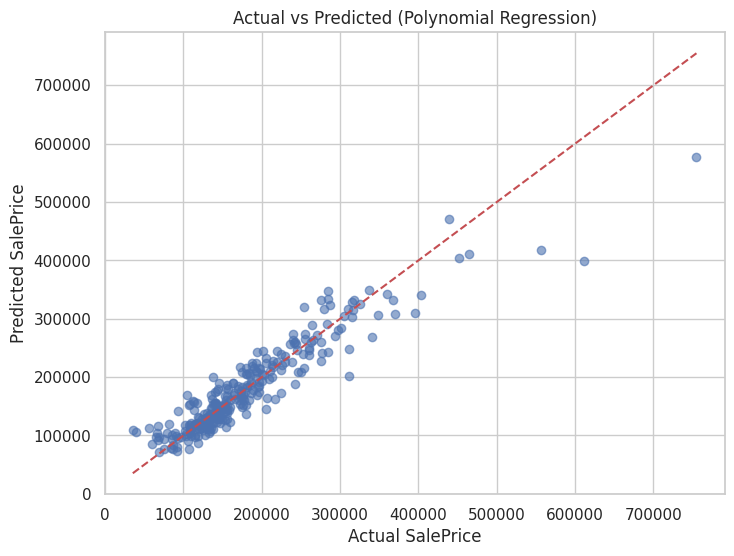

In [87]:
# Prediction vs actual plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted (Polynomial Regression)')
plt.show()


Interpretation of the plot:

1) Good Fit: The closer the scatter points are to the red dashed line, the better the model's predictions align with the actual values.
2) Over-prediction/Under-prediction: Points above the red line indicate that the model over-predicted the SalePrice, while points below the line indicate under-prediction.
3) Variance: The spread of the points around the line gives an idea of the model's consistency and error magnitude. A wider spread indicates more variability in prediction errors.


---


* Actual vs Predicted" Plot's Purpose: This plot evaluates how well your model's predictions match the true values.

In [89]:
# Short definitions (print)
definitions = {
    "Distribution plot": "Visualizes the distribution of a single variable; often histogram + KDE.",
    "Boxplot": "Shows median, quartiles and potential outliers of a distribution.",
    "Violin plot": "Density shape + boxplot inside; good for comparing distributions across groups.",
    "Pandas imputer": "Using pandas .fillna() to replace missing values.",
    "Iterative imputer": "Multivariate imputation (MICE-like); models each column with others iteratively.",
    "KNN imputer": "Imputes missing values using nearest neighbor averages in feature space.",
    "LGBM imputer": "Use LightGBM model to predict missing values per column using other features.",
    "Chatterjee correlation": "A recently proposed rank-based correlation measuring functional dependence.",
    "ANOVA": "Analysis of variance - tests for mean differences across groups.",
    "AIC": "Akaike Information Criterion: 2k - 2 ln(L). Lower is better.",
    "Likelihood": "Probability of observed data under a model; higher is better for model fit."
}
for k,v in definitions.items():
    print(f"{k}:\n  {v}\n")


Distribution plot:
  Visualizes the distribution of a single variable; often histogram + KDE.

Boxplot:
  Shows median, quartiles and potential outliers of a distribution.

Violin plot:
  Density shape + boxplot inside; good for comparing distributions across groups.

Pandas imputer:
  Using pandas .fillna() to replace missing values.

Iterative imputer:
  Multivariate imputation (MICE-like); models each column with others iteratively.

KNN imputer:
  Imputes missing values using nearest neighbor averages in feature space.

LGBM imputer:
  Use LightGBM model to predict missing values per column using other features.

Chatterjee correlation:
  A recently proposed rank-based correlation measuring functional dependence.

ANOVA:
  Analysis of variance - tests for mean differences across groups.

AIC:
  Akaike Information Criterion: 2k - 2 ln(L). Lower is better.

Likelihood:
  Probability of observed data under a model; higher is better for model fit.



### Visualizing the Polynomial Regression Curve for `GrLivArea`

* To see how the polynomial model captures a non-linear relationship, we can plot one of the key predictors (e.g., `GrLivArea`) against `SalePrice` and overlay the model's predictions.
* For this, we'll keep other features constant (at their mean values from the training set) and vary only `GrLivArea` to observe its non-linear effect on `SalePrice`.

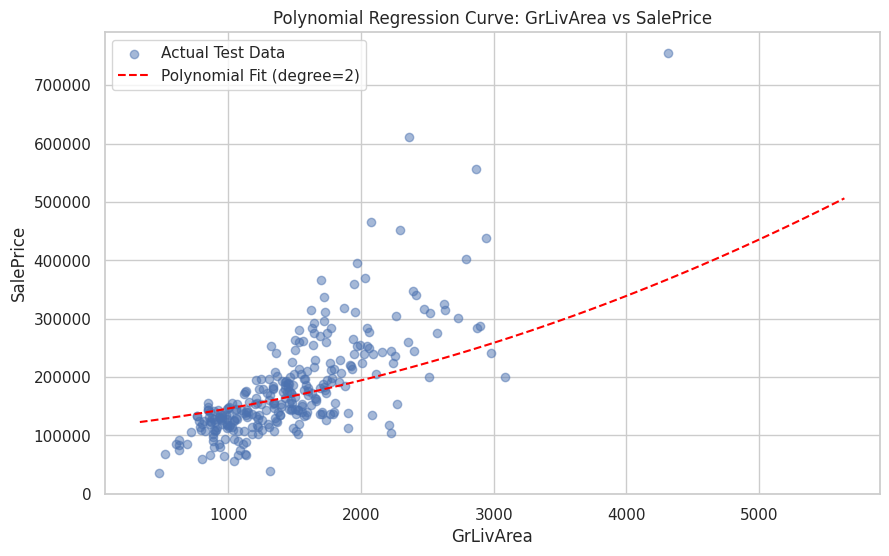

In [90]:
# Select 'GrLivArea' to visualize its relationship with SalePrice
predictor_to_plot = 'GrLivArea'

# Create a range of GrLivArea values for plotting the curve
min_grliv = X_train[predictor_to_plot].min()
max_grliv = X_train[predictor_to_plot].max()
grliv_range = np.linspace(min_grliv, max_grliv, 100).reshape(-1, 1)

# Create a DataFrame for prediction, filling other predictors with their mean values from the training set
# This isolates the effect of GrLivArea
X_plot = pd.DataFrame(np.tile(X_train.mean().values, (100, 1)), columns=predictors)
X_plot[predictor_to_plot] = grliv_range # Replace GrLivArea with the varied range

# Transform these synthetic data points into polynomial features
X_plot_poly = poly.transform(X_plot)

# Predict SalePrice using the trained linear regression model
y_plot_pred = lr.predict(X_plot_poly)

# Plotting
plt.figure(figsize=(10, 6))
# Scatter plot of actual GrLivArea vs SalePrice from the test set
plt.scatter(X_test[predictor_to_plot], y_test, alpha=0.5, label='Actual Test Data')

# Plot the polynomial regression curve
plt.plot(X_plot[predictor_to_plot], y_plot_pred, color='red', linestyle='--', label=f'Polynomial Fit (degree={degree})')

plt.title(f'Polynomial Regression Curve: {predictor_to_plot} vs SalePrice')
plt.xlabel(predictor_to_plot)
plt.ylabel('SalePrice')
plt.legend()
plt.grid(True)
plt.show()

* Unlike the "Actual vs Predicted" plot, where you ideally want a straight line (indicating perfect prediction accuracy), this plot reveals the non-linear relationship that your polynomial model has learned between a specific predictor (GrLivArea) and the target variable (SalePrice).
* As you can see, the red dashed line is indeed a curve (specifically, a parabola for degree 2), illustrating how SalePrice is predicted to change in a non-linear fashion as GrLivArea  increases.
* This demonstrates the model's ability to capture more complex relationships than a simple linear regression model, which would have produced a straight line. The scatter points around the curve indicate the model's predictions relative to the actual data for this specific feature.

In [91]:
import joblib

# Save the PolynomialFeatures transformer
joblib.dump(poly, 'polynomial_features_transformer.joblib')
print("PolynomialFeatures transformer saved as 'polynomial_features_transformer.joblib'")

# Save the trained LinearRegression model
joblib.dump(lr, 'polynomial_regression_model.joblib')
print("Polynomial Regression model saved as 'polynomial_regression_model.joblib'")

PolynomialFeatures transformer saved as 'polynomial_features_transformer.joblib'
Polynomial Regression model saved as 'polynomial_regression_model.joblib'


Make a prediction

In [95]:
# Load the PolynomialFeatures transformer
loaded_poly = joblib.load('polynomial_features_transformer.joblib')
print("PolynomialFeatures transformer loaded.")

# Load the trained LinearRegression model
loaded_lr = joblib.load('polynomial_regression_model.joblib')
print("Polynomial Regression model loaded.")

# Define the predictors used in your model (must match the original training features)
predictors = ['OverallQual', 'GrLivArea', 'YearBuilt', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'LotArea']

# Create a new data point for a hypothetical house
# You can change these values to see how the prediction changes
new_house_features = pd.DataFrame([
    {
        'OverallQual': 7,       # Overall material and finish quality (1-10)
        'GrLivArea': 2000,      # Above grade (ground) living area square feet
        'YearBuilt': 2010,      # Original construction date
        'TotalBsmtSF': 1000,    # Total square feet of basement area
        '1stFlrSF': 1000,       # First Floor square feet
        'FullBath': 2,          # Full bathrooms above grade
        'LotArea': 8000         # Lot size in square feet
    }
])

print("\n--- New House Features ---")
print(new_house_features)

# Transform these new original features into polynomial features
new_data_poly_features = loaded_poly.transform(new_house_features)

# Predict the SalePrice using the loaded linear regression model
predicted_price = loaded_lr.predict(new_data_poly_features)

print(f"\nPredicted SalePrice for the new house: ${predicted_price[0]:,.2f}")

# Optional: You can also print the polynomial features if you want to inspect them
# poly_feature_names = loaded_poly.get_feature_names_out(predictors)
# new_data_poly_df = pd.DataFrame(new_data_poly_features, columns=poly_feature_names)
# print("\n--- New House Polynomial Features ---")
# print(new_data_poly_df)

PolynomialFeatures transformer loaded.
Polynomial Regression model loaded.

--- New House Features ---
   OverallQual  GrLivArea  YearBuilt  TotalBsmtSF  1stFlrSF  FullBath  LotArea
0            7       2000       2010         1000      1000         2     8000

Predicted SalePrice for the new house: $240,598.18
